In [1]:
!pip install imblearn

     |████████████████████████████████| 167 kB 506 kB/s eta 0:00:01


In [2]:
import os
import pdb

import numpy as np
import pandas as pd
from sklearn import preprocessing


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import regularizers

In [4]:
from src.features_generation import feature_engineering

In [5]:
X, y, X_sub, sample_submission = feature_engineering()

In [6]:
X.shape

(590540, 240)

In [7]:
X.fillna(-999, inplace=True)

In [9]:
y.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_sample(X, y)
#X_sm,y_sm = X,y

In [11]:
y_sm.value_counts()

1    569877
0    569877
Name: isFraud, dtype: int64

In [12]:
from tensorflow.keras.utils import to_categorical

In [17]:
y_sm[:5]

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int64

In [18]:
y_cat = to_categorical(y_sm)
#arg 0: true
#arg 1: fraud

In [19]:
y_cat[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [20]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_sm = scaler.fit_transform(X_sm)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_cat, test_size=0.2, random_state=42)

In [22]:
np.argmax(y_train, axis =1).sum() #num of fraud in training data

455854

In [23]:
np.argmax(y_test, axis =1).sum()

114023

In [24]:
len(y_train)

911803

In [25]:
X_train.shape

(911803, 240)

In [76]:
model = Sequential()
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001),input_dim=240))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# model.add(Dense(100, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# 
model.add(Dense(2, activation='softmax'))
model.summary()

# Compiling the model using categorical_crossentropy loss, and rmsprop optimizer.
model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data= (X_test,y_test), epochs=20, batch_size=10000)
#history = model.fit(X_train, y_train, validation_data= (X_test,y_test), epochs=10)
#, verbose=0

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 256)               61696     
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_32 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)              

In [29]:
from sklearn.metrics import f1_score, roc_curve, auc

In [77]:
y_pred = model.predict(X_test)

In [78]:
y_pred_class = np.argmax(y_pred, axis =1)
y_test_class = np.argmax(y_test, axis =1)
f1_score(y_test_class, y_pred_class)

0.8476489516296449

In [79]:
fpr, tpr, thresholds = roc_curve(y_test_class, y_pred_class)
auc(fpr, tpr)

0.8454609664544457

In [75]:
model.save('10ep_best_model') 

INFO:tensorflow:Assets written to: 10ep_best_model/assets


In [162]:
y_pred_class.sum()

99184

In [163]:
y_test_class.sum()

114023

In [164]:
y_pred[:5]

array([[0.84668094, 0.15331909],
       [0.86789393, 0.13210604],
       [0.06398497, 0.93601507],
       [0.07493328, 0.92506677],
       [0.52853334, 0.47146672]], dtype=float32)

In [132]:
y_test[:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [93]:
y_test_class #mark "1" is fraud

array([0, 0, 1, ..., 0, 1, 0])

In [80]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='validation')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


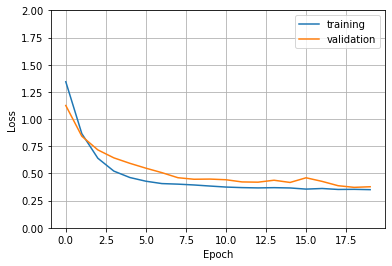

In [81]:
plot_loss(history)

In [82]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='training')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.ylim([0.5, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

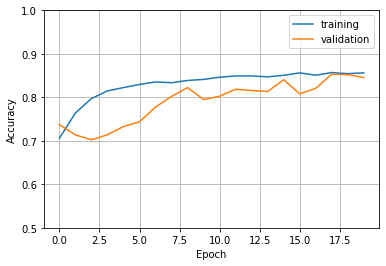

In [83]:
plot_accuracy(history)

In [32]:
#submission
X_sub = X_sub.fillna(-999)
X_sub =scaler.transform(X_sub)

In [33]:
y_sub = model.predict(X_sub)
y_sub_class = np.argmax(y_sub, axis =1)

In [34]:
y_sub_class.sum()

47124

In [35]:
len(X_sub)

506691

In [36]:
sample_submission['isFraud'] = y_sub_class
sample_submission.to_csv('dnn_submission.csv', index=False)

In [37]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0


In [173]:
#without SMOTE,  kaggle score 0.566
#with SMOTE,  kaggle score 0.770